## Tugas Praktikum


1. Buatlah model SVM dengan menggunakan data voice.csv dengan ketentuan,
  
    a. Split data dengan rasio 70:30 dan 80:20 untuk setiap model yang akan dibangun.
        
        i. Gunakan model dengan kernel linier.
        ii. Gunakan model dengan kernel polynomial.
        iii. Gunakan model dengan kernel RBF.

    b. Tabulasikan performansi setiap split dan kernel berdasarkan metrik akurasi.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Load dataset
df = pd.read_csv('C:\\kuliah\\Machine Leaning\\2341720003_ML_2025\\data\\voice.csv')

In [76]:
# Pisahkan fitur (X) dan label (y)
X = df.drop('label', axis=1)
y = df['label']

In [77]:
# Encoding label dan standarisasi fitur
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [78]:
# Split data (70:30 dan 80:20)
splits = {
    "70:30": train_test_split(X_scaled, y, test_size=0.3, random_state=42),
    "80:20": train_test_split(X_scaled, y, test_size=0.2, random_state=42)
}

In [79]:
# Buat model SVM dengan 3 kernel berbeda
kernels = ["linear", "poly", "rbf"]
results = []

for ratio, (X_train, X_test, y_train, y_test) in splits.items():
    for k in kernels:
        model = SVC(kernel=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append({
            "Split": ratio,
            "Kernel": k,
            "Akurasi": round(acc, 4)
        })


In [80]:
hasil = pd.DataFrame(results)
print("\n=== Tabel Perbandingan Akurasi SVM ===")
print(hasil)


=== Tabel Perbandingan Akurasi SVM ===
   Split  Kernel  Akurasi
0  70:30  linear   0.9706
1  70:30    poly   0.9569
2  70:30     rbf   0.9811
3  80:20  linear   0.9763
4  80:20    poly   0.9685
5  80:20     rbf   0.9826


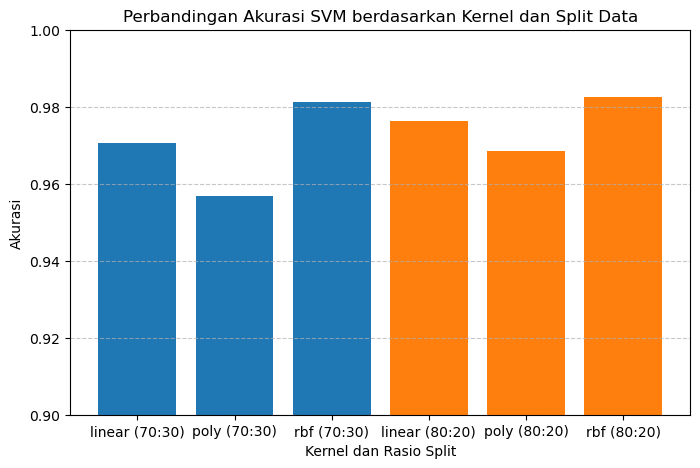

In [81]:
plt.figure(figsize=(8,5))
for split in hasil["Split"].unique():
    subset = hasil[hasil["Split"] == split]
    plt.bar(subset["Kernel"] + " (" + split + ")", subset["Akurasi"], label=split)

plt.title("Perbandingan Akurasi SVM berdasarkan Kernel dan Split Data")
plt.xlabel("Kernel dan Rasio Split")
plt.ylabel("Akurasi")
plt.ylim(0.9, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

2. Gunakan data pada praktikum 5 untuk membuat model klasifikasi siang dan malam menggunakan SVM dengan kernel RBF menggunakan fitur histrogram. Gunakan rasio 80:20. Anda dapat bereksperimen dengan hyperparameter tunning dari kernel RBF. Catat performansi akurasinya!

In [82]:
from pathlib import Path
import matplotlib.image as mpimg

# Load Dataset
train_dir = "C:\\kuliah\\Machine Leaning\\2341720003_ML_2025\\data\\images\\training\\"
test_dir = "C:\\kuliah\\Machine Leaning\\2341720003_ML_2025\\data\\images\\test\\"

# Fungsi untuk memuat dataset
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')
    img_list = []
    for dir in dirs:
        label = dir.name  # lebih rapi
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)
            if img is not None:
                img_list.append((img, label))
    return img_list

# Gabungkan train dan test agar bisa di-split lagi
train_img = load_dataset(train_dir)
test_img = load_dataset(test_dir)
all_img = train_img + test_img

print(f"Total images: {len(all_img)}")


Total images: 400


In [83]:
# Pra Pengolahan Data
import cv2

def standarized_input(image):
    return cv2.resize(image, (1100, 600))

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    std_img_list = []
    for img, label in img_list:
        std_img = standarized_input(img)
        num_label = label_encoder(label)
        std_img_list.append((std_img, num_label))
    return std_img_list

processed_img = preprocess(all_img)


In [84]:
# Ekstraksi Fitur Histogram
def extract_hist_feature(image):
    # Konversi ke HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Ambil histogram untuk setiap channel (H, S, V)
    hist_h = cv2.calcHist([hsv], [0], None, [32], [0, 256])
    hist_s = cv2.calcHist([hsv], [1], None, [32], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [32], [0, 256])

    # Normalisasi dan gabungkan
    hist = np.concatenate((hist_h, hist_s, hist_v)).flatten()
    hist = hist / np.sum(hist)
    return hist

# Buat dataset fitur
features = []
labels = []
for img, label in processed_img:
    feat = extract_hist_feature(img)
    features.append(feat)
    labels.append(label)

features = np.array(features)
labels = np.array(labels)
print("Feature shape:", features.shape)


Feature shape: (400, 96)


In [85]:
# Split Data (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

In [86]:
# Model SVM RBF
# Coba beberapa kombinasi parameter RBF
params = [
    {'C': 1, 'gamma': 'scale'},
    {'C': 10, 'gamma': 'scale'},
    {'C': 1, 'gamma': 0.01},
    {'C': 10, 'gamma': 0.01},
]

results = []

for p in params:
    model = SVC(kernel='rbf', C=p['C'], gamma=p['gamma'])
    model.fit(X_train, y_train)

    # Evaluasi
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    results.append({
        'C': p['C'],
        'gamma': p['gamma'],
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    })

# Tampilkan hasil dalam bentuk tabel
results_df = pd.DataFrame(results)
print(results_df)


    C  gamma  Train Accuracy  Test Accuracy
0   1  scale        1.000000         0.9875
1  10  scale        1.000000         0.9875
2   1   0.01        0.884375         0.9000
3  10   0.01        0.884375         0.9000


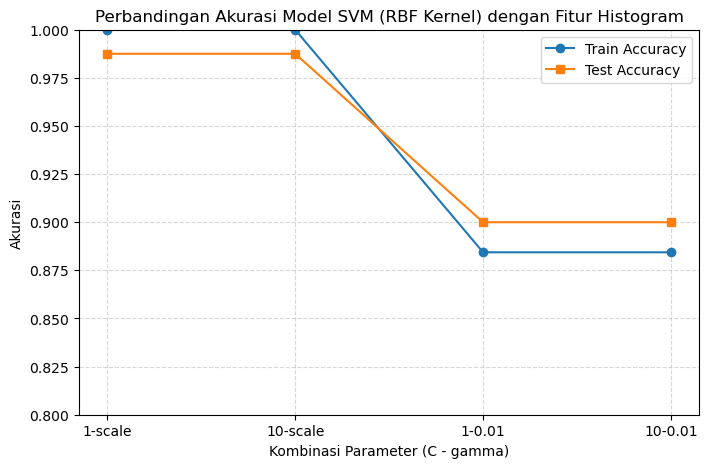

In [87]:
# Plot perbandingan akurasi
plt.figure(figsize=(8,5))
plt.plot(results_df['C'].astype(str) + "-" + results_df['gamma'].astype(str),
         results_df['Train Accuracy'], marker='o', label='Train Accuracy')
plt.plot(results_df['C'].astype(str) + "-" + results_df['gamma'].astype(str),
         results_df['Test Accuracy'], marker='s', label='Test Accuracy')

plt.title("Perbandingan Akurasi Model SVM (RBF Kernel) dengan Fitur Histogram")
plt.xlabel("Kombinasi Parameter (C - gamma)")
plt.ylabel("Akurasi")
plt.ylim(0.8, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()